# Supernova Host Target Selection

This notebook compares the master list of supernova host targets produced by Maayane Soumagnac and Peter Nugent and published in [DESI-doc-5430](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=5430) against DR8 bright and dark targets.

A simple angular separation cut between the SN host RA,Dec and the target catalogs is applied.

In [1]:
from desitarget import io
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import healpy as hp
from astropy.io import ascii
from astropy.table import Table, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

mpl.rc('font', size=14)

## SN Host Master List

In [2]:
sntargets = ascii.read('master_host_clean.csv')
sntargets

sn name,index,hemisphere,ra,dec,sn_z,host_ra,host_dec,program,priority
str12,float64,str5,float64,float64,float64,float64,float64,str15,float64
09bce,1.0,north,248.825,55.6331,0.023,248.825666667,55.6344166667,IIps,2.0
09fbf,1.0,north,320.16,1.04803,0.020744,320.159333333,1.04719444444,IIps,4.0
09fbf,2.0,north,320.16,1.04803,0.020744,320.15332,1.052773,IIps,4.0
10aauv,1.0,north,107.855,49.9426,0.023,107.855190525,49.9429865759,IIps,2.0
10bau,1.0,south,139.089,17.7278,0.025958999999999996,139.090375,17.7272222222,IIps,2.0
10bgl,1.0,north,154.77,46.4565,0.03,154.771375,46.4541111111,IIps,2.0
10dvb,1.0,north,259.051,31.7933,0.022941999999999997,259.044333333,31.7923055556,IIps,2.0
10hny,1.0,north,226.105,49.4008,0.026548000000000002,226.102875,49.39875,IIps,2.0
10hny,2.0,north,226.105,49.4008,0.026548000000000002,226.1004,49.40329,IIps,2.0


### SN Host SkyCoords

Compute a `SkyCoord` array; useful for later nearest-neighbor comparisons with the target catalog.

In [3]:
sncoords = SkyCoord(ra=sntargets['host_ra'], dec=sntargets['host_dec'], unit='deg')

### Plot SN Host Coordinates

Plot the SN host positions, color-coded by SN program as identified in the master list.

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
Anna 8 8
IIps 55 63
RCF 1106 1169
RCF/IIps 10 1179
RCF/RCF 2 1181
SNe_Ia 7429 8610
SNe_Ia/Anna 2 8612
SNe_Ia/IIps 13 8625
SNe_Ia/RCF 2129 10754
SNe_Ia/RCF/Anna 4 10758
SNe_Ia/RCF/IIps 69 10827


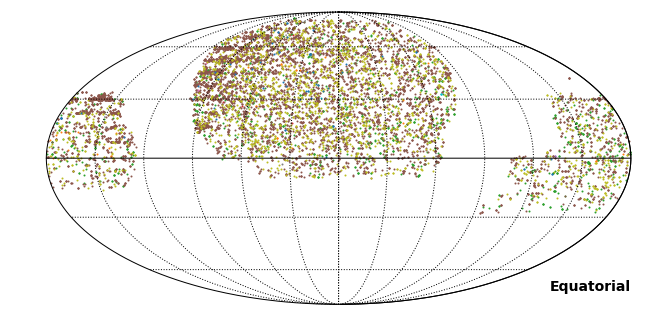

In [4]:
nside = 4
npix = hp.nside2npix(nside)
bkg = np.zeros(npix)
hp.mollview(bkg, cmap='binary', min=0, max=1, cbar=False, flip='astro', rot=180, coord='C', title='')
hp.graticule()

progs = np.unique(sntargets['program'])
tot = 0
for prog in progs:
    select = sntargets['program'] == prog
    tot += np.sum(select)
    print(prog, np.sum(select), tot)
    hp.projscatter(sntargets['host_ra'][select], sntargets['host_dec'][select],
                   lonlat=True, marker='o', s=1,
                   label=prog);

# plt.legend()

## DR8 Target List

Load the DR8 target lists on NERSC.

In [5]:
dr8_bright = '/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright'
dr8_dark = '/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/dark'

dr8_files = sorted(glob('{}/*.fits'.format(dr8_bright))) + sorted(glob('{}/*.fits'.format(dr8_dark)))

### Compare Target RA,Dec to SN Host Location

Spin through all the DR8 target files (bright and dark time selection) without any object masks applied, and simply look for any target within a small distance (e.g., $1''$) from a SN host.

In [6]:
readcols = ['TARGETID','RA','DEC','FLUX_G','FLUX_R','FLUX_Z', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET']

selected_targets = None

# Spin through all DR8 files.
for dr8_file in dr8_files:
    # Construct an array of target SkyCoords.
    targets = io.read_target_files(dr8_file, columns=readcols)
    targetcoords = SkyCoord(ra=targets['RA'], dec=targets['DEC'], unit='deg')
    
    # Compute nearest-neighbor distances.
    idx, sep2d, dist3d = match_coordinates_sky(targetcoords, sncoords)
    
    # Select all close targets and append them to a table.
    select = sep2d < 1*u.arcsec
    if selected_targets is None:
        selected_targets = targets[select]
    else:
        selected_targets = np.hstack([selected_targets, targets[select]])
    
    # Just for tracking, print the number selected and the cumulative size of the stacked target list.
    print(dr8_file)
    print(np.sum(select), len(selected_targets))

/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright/targets-dr8-hp-0.fits
59 59
/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright/targets-dr8-hp-1.fits
0 59
/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright/targets-dr8-hp-10.fits
382 441
/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright/targets-dr8-hp-11.fits
352 793
/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright/targets-dr8-hp-12.fits
81 874
/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright/targets-dr8-hp-13.fits
58 932
/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright/targets-dr8-hp-14.fits
161 1093
/global/projecta/projectdirs/desi/target/catalogs/dr8/0.32.0/targets/main/resolve/bright/targets-dr8-hp-15.fits
54 1147
/global/projecta/projectdirs/desi/target/catalog

### Check Unique Targets and Plot Positions

In [7]:
selected_targets = unique(Table(selected_targets))

In [8]:
selected_targets

RA,DEC,FLUX_G,FLUX_R,FLUX_Z,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET
float64,float64,float32,float32,float32,int64,int64,int64,int64
0.3107400027145378,28.858515161544602,59.842617,129.29637,212.59895,35186424743464252,1152921504606846976,131074,0
0.3223348230542077,31.227623121864298,1.6461449,5.2335725,15.825504,35186477205817470,268501001,0,0
0.5534030648419186,26.356648641763098,61.533913,125.34999,224.12729,35186371014430366,1152921504606846976,131074,0
0.5728411919051729,27.91509294463189,45.003296,107.754036,210.18095,35186408758968949,1152921504606846976,131074,0
0.6414931165408103,2.3325828328963683,56.614162,141.20287,290.84152,35185812119231238,1152921504606846976,131074,0
0.6466428559922484,10.866977964485049,48.818268,95.122185,172.68155,35186016205672715,1152921504606846976,131074,0
0.663959029683103,2.3357507303931233,115.75424,284.78015,535.50507,35185812119231327,1152921504606846976,131074,0
0.8012377653777681,-10.834768815881368,194.45332,340.14297,507.00223,35185499421278524,1152921504606846976,131074,0
0.8034943488543913,24.999883256802338,2.7954688,15.334429,37.054817,35186343713703988,1152921504875347977,131074,0


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


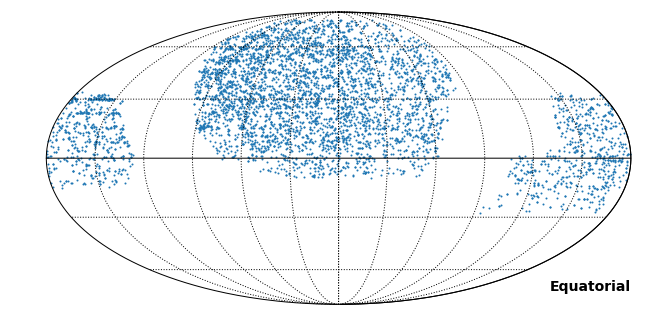

In [9]:
hp.mollview(bkg, cmap='binary', min=0, max=1, cbar=False, flip='astro', rot=180, coord='C', title='')
hp.graticule()
hp.projscatter(selected_targets['RA'], selected_targets['DEC'],
               lonlat=True, marker='o', s=1);

In [11]:
selected_targets.write('snhost_dr8_target.fits')